# August 28 - Training on 9M event dataset metrics

In [2]:
# Default imports
import math
import os
import sys
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils
import random
import torch
from plot_utils import notebook_utils_2

## Scratch - Extract the values from the saved .npz array

In [ ]:
dump_npz_path = "/home/akajal/WatChMaL/VAE/dumps/20190828_235444/test_valid_iteration_metrics.npz"
dump_npz_arr = np.load(dump_npz_path)

In [ ]:
print(list(dump_npz_arr.keys()))

In [ ]:
indices, recon_loss, kl_loss = dump_npz_arr["indices"], dump_npz_arr["recon_loss"], dump_npz_arr["kl_loss"]
print(indices.shape)
print(recon_loss.shape)
print(kl_loss.shape)

## Searching for duplicates in the npz list

In [ ]:
counts = np.bincount(indices)
print(np.where(counts > 1)[0])

In [ ]:
print(recon_loss[:10])
print(kl_loss[:10])

In [ ]:
print(indices[:10])

## Analyzing the metric dumps

### Checking the indices exist in the dumps for all the latent dimensions

In [3]:
latent_dims = [16, 32, 64, 128, 256]
dumps = ["20190829_010238", "20190829_010252", "20190829_010339", "20190829_010405", "20190829_010431"]

# First check that all the indices from the test validation set exist in all the dumps

ldump_idx_arr = None

# Iterate over the dumps and check the indices
for latent_dim, dump in zip(latent_dims, dumps):
    print("----------------------------------------------------")
    print("Reading metrics from VAE with {0} latent dimensions :".format(latent_dim))
    print("----------------------------------------------------")
    
    dump_npz_path = "/home/akajal/WatChMaL/VAE/dumps/{0}/test_valid_iteration_metrics.npz".format(dump)
    dump_npz_arr = np.load(dump_npz_path)
    
    dump_indices = np.sort(dump_npz_arr["indices"])
    
    if ldump_idx_arr is not None:
        if not np.array_equal(dump_indices, ldump_idx_arr):
            print("Index array for latent dims {0} not equal to all the other.".format(latent_dim))
        else:
            print("Index array equal to the first index array")
    else:
        ldump_idx_arr = dump_indices

----------------------------------------------------
Reading metrics from VAE with 16 latent dimensions :
----------------------------------------------------
----------------------------------------------------
Reading metrics from VAE with 32 latent dimensions :
----------------------------------------------------
Index array equal to the first index array
----------------------------------------------------
Reading metrics from VAE with 64 latent dimensions :
----------------------------------------------------
Index array equal to the first index array
----------------------------------------------------
Reading metrics from VAE with 128 latent dimensions :
----------------------------------------------------
Index array equal to the first index array
----------------------------------------------------
Reading metrics from VAE with 256 latent dimensions :
----------------------------------------------------
Index array equal to the first index array


### Print the first level metrics from the dumps

In [4]:
latent_dims = [16, 32, 64, 128, 256]
dumps = ["20190829_010238", "20190829_010252", "20190829_010339", "20190829_010405", "20190829_010431"]

# Metrics for plotting
recon_loss_values, kl_loss_values = [], []
recon_std_values, kl_std_values, recon_stderr_values, kl_stderr_values = [], [], [], []

# Iterate over the dumps and check the indices
for latent_dim, dump in zip(latent_dims, dumps):
    print("----------------------------------------------------")
    print("Printing metrics for VAE with {0} latent dimensions :".format(latent_dim))
    print("----------------------------------------------------")
    
    dump_npz_path = "/home/akajal/WatChMaL/VAE/dumps/{0}/test_valid_iteration_metrics.npz".format(dump)
    npz_arr = np.load(dump_npz_path)
    
    dump_recon_loss, dump_kl_loss = npz_arr["recon_loss"], npz_arr["kl_loss"]
    
    mean_recon_loss, std_recon_loss = np.mean(dump_recon_loss), np.std(dump_recon_loss)
    stderr_recon_loss = std_recon_loss/math.sqrt(dump_recon_loss.shape[0])
    
    recon_loss_values.append(mean_recon_loss)
    recon_std_values.append(std_recon_loss)
    recon_stderr_values.append(stderr_recon_loss)
    
    mean_kl_loss, std_kl_loss = np.mean(dump_kl_loss), np.std(dump_kl_loss)
    stderr_kl_loss = std_kl_loss/math.sqrt(dump_kl_loss.shape[0])
    
    kl_loss_values.append(mean_kl_loss)
    kl_std_values.append(std_kl_loss)
    kl_stderr_values.append(stderr_kl_loss)
    
    print("Recon Loss metrics")
    print("Mean Recon loss : {0}".format(mean_recon_loss))
    print("Std Recon loss : {0}".format(std_recon_loss))
    print("Stderr Recon loss : {0}\n".format(stderr_recon_loss))
    
    print("KL Loss metrics")
    print("Mean KL loss : {0}".format(mean_kl_loss))
    print("Std KL loss : {0}".format(std_kl_loss))
    print("Stderr KL loss : {0}".format(stderr_kl_loss))

----------------------------------------------------
Printing metrics for VAE with 16 latent dimensions :
----------------------------------------------------
Recon Loss metrics
Mean Recon loss : 8958.9755859375
Std Recon loss : 5998.86669921875
Stderr Recon loss : 6.327784681298076

KL Loss metrics
Mean KL loss : 54.29353332519531
Std KL loss : 25.35870933532715
Stderr KL loss : 0.026749127879516207
----------------------------------------------------
Printing metrics for VAE with 32 latent dimensions :
----------------------------------------------------
Recon Loss metrics
Mean Recon loss : 8853.7060546875
Std Recon loss : 6004.27734375
Stderr Recon loss : 6.333491991578074

KL Loss metrics
Mean KL loss : 54.090919494628906
Std KL loss : 22.656230926513672
Stderr KL loss : 0.02389847252505471
----------------------------------------------------
Printing metrics for VAE with 64 latent dimensions :
----------------------------------------------------
Recon Loss metrics
Mean Recon loss 

### Plot the per-sample measure

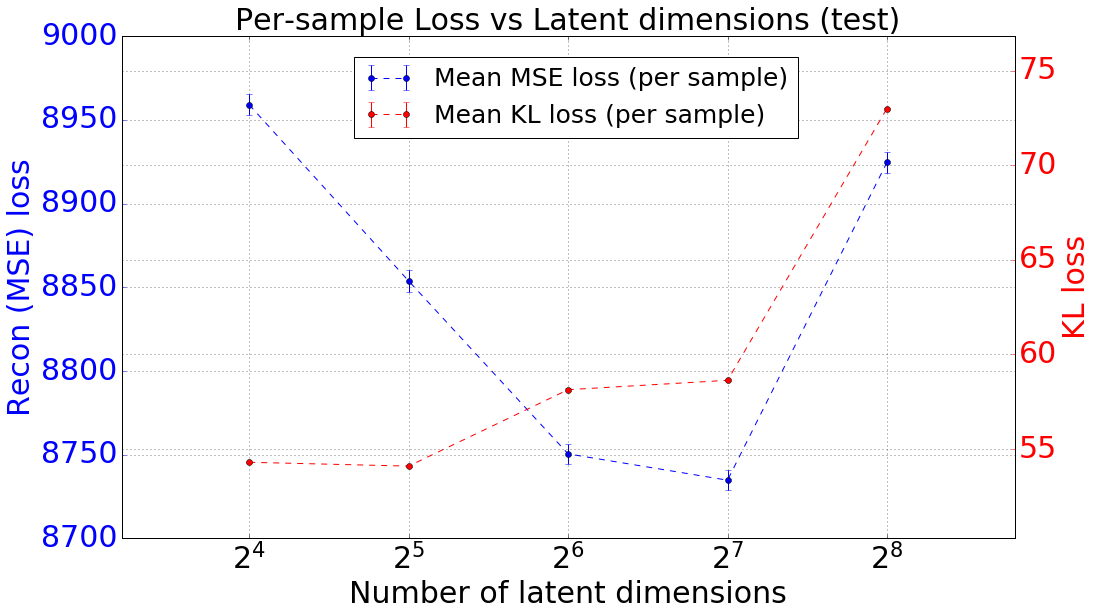

In [6]:
# Plot the metrics for the training subset

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(16,9))

# Set the x-axes ticks for the plot
ax1.set_xticks(latent_dims)

# Use the same x-axis to plot the KL loss
ax2 = ax1.twinx()

# Plot the MSE values collected above
ax1.errorbar(latent_dims, recon_loss_values, yerr=recon_stderr_values, linestyle='dashed', marker='o',
             color="blue", label="Mean MSE loss (per sample)")

# Plot the KL values collected above
ax2.errorbar(latent_dims, kl_loss_values, yerr=kl_stderr_values, linestyle='dashed', marker='o',
             color="red", label="Mean KL loss (per sample)")

# Setup plot characteristics
ax1.tick_params(axis="x", labelsize=30)
ax1.set_xlabel("Number of latent dimensions", fontsize=30)
ax1.set_xscale("log", basex=2)

ax1.set_ylabel("Recon (MSE) loss", fontsize=30, color="blue")
ax1.tick_params(axis="y", labelsize=30, colors="blue")

ax2.set_ylabel("KL loss", fontsize=30, color="red")
ax2.tick_params(axis="y", labelsize=30, colors="red")

plt.margins(0.2)
ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('white')
ax2.set_facecolor('white')

plt.title("Per-sample Loss vs Latent dimensions (test)", fontsize=30)

lgd = fig.legend(prop={"size":25}, loc='center', bbox_to_anchor=(0.5, 0.8))

### The above is a per-sample measure. How about per-batch ?

In [ ]:
# Metrics for plotting
recon_loss, kl_loss = [], []
recon_std_values, kl_std_values, recon_stderr_values, kl_stderr_values = [], [], [], []

In [ ]:
def print_vae_test_metrics(run_id):
    
    # Using the absolute path
    dump_dir = "/home/akajal/WatChMaL/VAE/dumps/" + run_id + "/"
    train_val_log = dump_dir + "test_validation_log.csv"
    
    # Print the average metrics on the training subset
    log_df = pd.read_csv(train_val_log)
            
    # Extract the loss values from the csv file
    loss_values = log_df["loss"].values
    mse_loss_values  = log_df["recon_loss"].values
    kl_loss_values = log_df["kl_loss"].values
    
    test_total_loss = np.mean(loss_values)
    test_mse_loss, test_kl_loss  = np.mean(mse_loss_values), np.mean(kl_loss_values)
    test_mse_std, test_kl_std = np.std(mse_loss_values), np.std(kl_loss_values)
    test_mse_stderr, test_kl_stderr = test_mse_std/math.sqrt(mse_loss_values.shape[0]), test_kl_std/math.sqrt(kl_loss_values.shape[0])  
    
    recon_loss.append(test_mse_loss)
    kl_loss.append(test_kl_loss)
    
    recon_stderr_values.append(test_mse_stderr)
    kl_stderr_values.append(test_kl_stderr)
    
    # Print out the average values
    print("Recon Loss metrics")
    print("Mean Recon loss : {0}".format(test_mse_loss))
    print("Std Recon loss : {0}".format(std_recon_loss))
    print("Stderr Recon loss : {0}\n".format(stderr_recon_loss))
    
    print("KL Loss metrics")
    print("Mean KL loss : {0}".format(mean_kl_loss))
    print("Std KL loss : {0}".format(std_kl_loss))
    print("Stderr KL loss : {0}".format(stderr_kl_loss))

In [ ]:
# Iterate over the dumps and check the indices
for latent_dim, dump in zip(latent_dims, dumps):
    print("----------------------------------------------------")
    print("Printing metrics for VAE with {0} latent dimensions :".format(latent_dim))
    print("----------------------------------------------------")
    
    print_vae_test_metrics(dump)

### Plot the per-batch measure

In [ ]:
# Plot the metrics for the training subset

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(16,9))

# Set the x-axes ticks for the plot
ax1.set_xticks(latent_dims)

# Use the same x-axis to plot the KL loss
ax2 = ax1.twinx()

# Plot the MSE values collected above
ax1.errorbar(latent_dims, recon_loss, yerr=recon_stderr_values, linestyle='dashed', marker='o',
             color="blue", label="Mean MSE loss (per batch sample)")

# Plot the KL values collected above
ax2.errorbar(latent_dims, kl_loss, yerr=kl_stderr_values, linestyle='dashed', marker='o',
             color="red", label="Mean KL loss (per batch sample)")

# Setup plot characteristics
ax1.tick_params(axis="x", labelsize=30)
ax1.set_xlabel("Number of latent dimensions", fontsize=30)
ax1.set_xscale("log", basex=2)

ax1.set_ylabel("Recon (MSE) loss", fontsize=30, color="blue")
ax1.tick_params(axis="y", labelsize=30, colors="blue")

ax2.set_ylabel("KL loss", fontsize=30, color="red")
ax2.tick_params(axis="y", labelsize=30, colors="red")

plt.margins(0.2)
ax1.grid(True)
ax2.grid(True)
plt.title("Per-batch-sample Loss vs Latent dimensions (test)", fontsize=30)

lgd = fig.legend(prop={"size":25}, loc='center', bbox_to_anchor=(0.5, 0.8))